In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import argparse
import yaml
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
# import cnns
# from cwvae import CWVAE, build_model
from cwvae2 import *
# from loggers.summary import Summary
# from loggers.checkpoint import Checkpoint
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# tf.disable_v2_behavior()

In [ ]:
cfg = tools.read_configs(
    "configs/mmnist.yml", "./configs/base_config.yml", datadir="datasets/moving_mnist/", logdir="./"
)
cfg["levels"] = 2
cfg["tmp_abs_factor"] = 2
cfg.open_loop_ctx = 2


In [ ]:
# model_components = build_model(cfg)
# model = model_components["meta"]["model"]

In [ ]:
# import cnns
# from cwvae import CWVAE
# # TODO: Rewrite with tf2.0
# # make sure works with mujoco-type datasets too
# encoder = cnns.Encoder(
#     cfg.levels,
#     cfg.tmp_abs_factor,
#     dense_layers=cfg.enc_dense_layers,
#     embed_size=cfg.enc_dense_embed_size,
#     channels_mult=cfg.channels_mult,
# )
# decoder = cnns.Decoder(cfg.channels, channels_mult=cfg.channels_mult)
# # then create CWVAE model
# model = CWVAE(
#     cfg.levels,
#     cfg.tmp_abs_factor,
#     dict(stoch=cfg.cell_stoch_size, deter=cfg.cell_deter_size),
#     cfg.cell_embed_size,
#     cfg.cell_type,
#     cfg.lr,
#     cfg.cell_min_stddev,
#     mean_only_cell=cfg.cell_mean_only,
#     reset_states=cfg.cell_reset_state,
# )

# obs_encoded = encoder(np.ones((10, 7, 64, 64, 1)))

In [ ]:
# these are the encoded states
# The fast variables have 6 states
# The slow variables have 3 states
# obs = np.ones((10, 7, 2))
# obs_encoded = encoder(obs)
# print(obs_encoded[0].shape, obs_encoded[1].shape)

In [ ]:
num_hidden = 32
output_dim = 1

# bottom layer
layer = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(output_dim, dtype=tf.float32),
        tf.keras.layers.Dense(32, dtype=tf.float32, activation="relu"),
        tf.keras.layers.Dense(num_hidden, dtype=tf.float32),
    ]
)

layers = []
layers.append(layer)

# top layer
for l in range(1, cfg.levels):
    layer = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(num_hidden, dtype=tf.float32),
            tf.keras.layers.Dense(num_hidden, dtype=tf.float32),
        ]
    )

    layers.append(layer)

encoder = Encoder3D(
    cfg.levels,
    cfg.tmp_abs_factor,
    layers=layers,
)

decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, dtype=tf.float32, activation="relu"),
        tf.keras.layers.Dense(output_dim, dtype=tf.float32),
    ]
)

model = CWVAE2(
    cfg.levels,
    cfg.tmp_abs_factor,
    dict(stoch=cfg.cell_stoch_size, deter=cfg.cell_deter_size),
    cfg.cell_embed_size,
    cfg.cell_type,
    cfg.lr,
    cfg.cell_min_stddev,
    encoder=encoder,
    decoder=decoder,
    mean_only_cell=cfg.cell_mean_only,
    reset_states=cfg.cell_reset_state,
)

2022-12-07 22:33:51.116773: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 22:33:51.670604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [ ]:
cfg.cell_embed_size, cfg.cell_deter_size, cfg.cell_stoch_size

(200, 200, 20)

In [ ]:
# obs = np.ones((10, 7, 2))

# load the synthetic linear with varying smoothness function
obs = np.load("../data/synthetic/linear_varyingsmoothness_full.npz")["y"]
obs = tf.Variable(np.transpose(obs, [1,0,2])[:, ::2,1:])

obs_encoded = model.encoder(obs)
outputs_bot, _, priors, posteriors = model.hierarchical_unroll(obs_encoded)

In [ ]:
# shape = [stoch_sample, h_t] -> cfg.cell_deter_size+cfg.cell_stoch_size dimensions
# outputs_bot.shape

In [ ]:
obs_decoded = decoder(outputs_bot)

In [ ]:
loss = model.compute_losses(
    obs,
    obs_decoded,
    priors,
    posteriors,
    dec_stddev=cfg.dec_stddev,
    kl_grad_post_perc=cfg.kl_grad_post_perc,
    free_nats=cfg.free_nats,
    beta=cfg.beta,
)
# out = {
#     "training": {
#         "obs": obs,
#         "encoder": encoder,
#         "decoder": decoder,
#         "obs_encoded": obs_encoded,
#         "obs_decoded": obs_decoded,
#         "priors": priors,
#         "posteriors": posteriors,
#         "loss": loss,
#     },
#     "meta": {"model": model},
# }

In [ ]:
# posteriors_recon, priors_onestep, priors_multistep = model.open_loop_unroll(
#     obs_encoded, cfg.open_loop_ctx, use_observations=cfg.use_obs
# )
# obs_decoded_posterior_recon = decoder(posteriors_recon[0]["output"])
# obs_decoded_prior_onestep = decoder(priors_onestep[0]["output"])
# obs_decoded_prior_multistep = decoder(priors_multistep[0]["output"])
# gt_multistep = obs[:, cfg.open_loop_ctx :, ...]
# out.update(
#     {
#         "open_loop_obs_decoded": {
#             "posterior_recon": obs_decoded_posterior_recon,
#             "prior_onestep": obs_decoded_prior_onestep,
#             "prior_multistep": obs_decoded_prior_multistep,
#             "gt_multistep": gt_multistep,
#         }
#     }
# )

In [ ]:

trainable_vars = model.trainable_variables
losses_train = []
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
saver = tf.compat.v1.train.Checkpoint(
    optimizer=optimizer,
    model=model,
    encoder=encoder,
    decoder=decoder,
)

iterator = trange(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
for i in iterator:
# for i in tqdm(range(100)):
#     if i % 10 == 0:
#         print(i)
    with tf.GradientTape() as tape:
        tape.watch(trainable_vars)
        
        obs_encoded = model.encoder(obs)
        outputs_bot, _, priors, posteriors = model.hierarchical_unroll(obs_encoded)
        obs_decoded = model.decoder(outputs_bot)
        loss = model.compute_losses(
            obs,
            obs_decoded,
            priors,
            posteriors,
            dec_stddev=cfg.dec_stddev,
            kl_grad_post_perc=cfg.kl_grad_post_perc,
            free_nats=cfg.free_nats,
            beta=cfg.beta,
        )
        losses_train.append(loss.numpy())

        # out = {
        #     "training": {
        #         "obs": obs,
        #         "encoder": encoder,
        #         "decoder": decoder,
        #         "obs_encoded": obs_encoded,
        #         "obs_decoded": obs_decoded,
        #         "priors": priors,
        #         "posteriors": posteriors,
        #         "loss": loss,
        #     },
        #     "meta": {"model": model},
        # }
        # posteriors_recon, priors_onestep, priors_multistep = model.open_loop_unroll(
        #     obs_encoded, cfg.open_loop_ctx, use_observations=cfg.use_obs
        # )
        # obs_decoded_posterior_recon = decoder(posteriors_recon[0]["output"])
        # obs_decoded_prior_onestep = decoder(priors_onestep[0]["output"])
        # obs_decoded_prior_multistep = decoder(priors_multistep[0]["output"])
        # gt_multistep = obs[:, cfg.open_loop_ctx :, ...]
        # out.update(
        #     {
        #         "open_loop_obs_decoded": {
        #             "posterior_recon": obs_decoded_posterior_recon,
        #             "prior_onestep": obs_decoded_prior_onestep,
        #             "prior_multistep": obs_decoded_prior_multistep,
        #             "gt_multistep": gt_multistep,
        #         }
        #     }
        # )

    grads = tape.gradient(loss, trainable_vars)
    grads = [np.nan_to_num(grad) for grad in grads]
    grads, global_norm = tf.clip_by_global_norm(grads, True)
    optimizer.apply_gradients(zip(grads, trainable_vars))
    iterator.set_description(
        f"EPOCH {i}, ELBO: {loss:1.4f}"
    )

KeyboardInterrupt: 

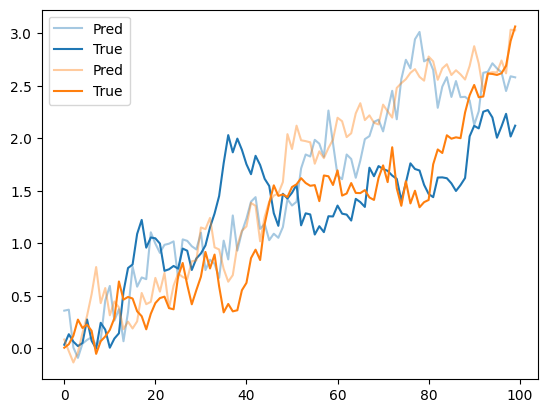

In [ ]:
for i in range(2):
    plt.plot(obs_decoded[i,:,0], label="Pred", color=f"C{i}", alpha=0.4, linestyle="-")
    plt.plot(obs[i,:,0], label="True", color=f"C{i}")
plt.legend()